This dataset can be found in https://www.kaggle.com/bulentesen/cardiac-arrhythmia-database

The algorithm that I will use will be a supervised learning algorithm because I have a labelled dataset. Given the great number of features, it seems that a decision tree based model which inherently selects the best features (the most informative) can be a suitable choice for a baseline model. I will first try a random forest because it is applicable to categorical and continuous data and it is an ensemble (bad predictions from a single weaker model (tree) will be cancelled out and the final decision comes from the aggregation of the outputs of a set of models (trees)).



Loading the dataset:

In [119]:
column_names = pd.read_csv('arrhythmia_column.names',header=None)

In [120]:
df = pd.read_csv('./arrhythmia.data', delimiter=',',names=column_names[0],na_values = ['?'])

In [121]:
df

,Age,Sex,Height,Weight,QRS Duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,V6_WA_Q Wave,V6_WA_R Wave,V6_WA_S Wave,V6_WA_R' Wave,V6_WA_S' Wave,V6_WA_P Wave,V6_WA_T Wave,V6_WA_QRSA,V6_WA_QRSTA,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,0.0,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,1
448,37,0,190,85,100,137,361,201,73,86,...,0.0,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,10
449,36,0,166,68,108,176,365,194,116,-85,...,0.0,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,2
450,32,1,155,55,93,106,386,218,63,54,...,-0.4,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,1



Check how the distribution of target class is:

In [122]:
df.Class.value_counts()

1     245
10     50
2      44
6      25
16     22
4      15
3      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: Class, dtype: int64

In [123]:
sum(df['Class']!=1) #check how many occurences of non-normal arrythmia exists

207

<font color='darkblue'>
There are 245 occurences of normal arrythmia and 207 occurences of non-normal arrythmia. As only patients with non-normal arrythmia are subjected to further examination (they are in risk of heart failure) it doesn't make sense to predict what class of arrythmia the patient has (even because there are certain types of arrythmia that don't even occur in this dataset, according with dataset description file "arrhythmia.names"). Furthermore, there aren't so many instances in this dataset that allows the algorithm to make a clear distinction (representativeness issue). For those reasons, I will transform this problem in a binary classification problem instead of a multi-class. This also generates a nearly balanced dataset from the target perspective.

In [124]:
df1 = df.copy() #create a copy of the original dataset

#setting prediction values to "Normal" or "Risk" based on column scores values
df1.loc[df1["Class"] == 1,"Class"] = "Normal"         #class 1 is normal arrythmia
df1.loc[df1["Class"] != "Normal","Class"] = "Risk"    #other classes are risk classes
df1.Class.value_counts()

Normal    245
Risk      207
Name: Class, dtype: int64

<font color='darkblue'>
Checking features that I am familiar with to see if there are any uncomon values:

Histogram for Age:


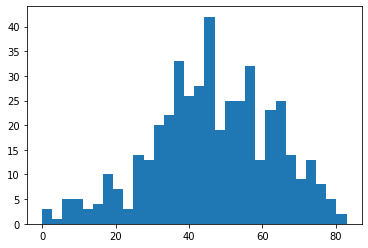

Histogram for Sex:


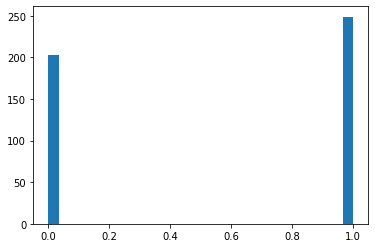

Histogram for Height:


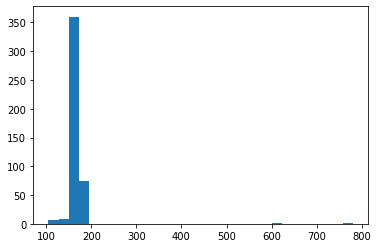

Histogram for Weight:


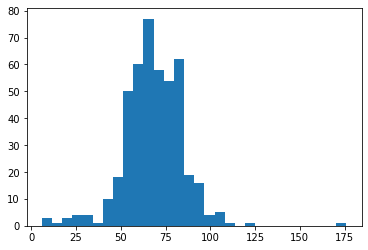

Histogram for Heart rate bpm:


C:\Users\mtava\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\mtava\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


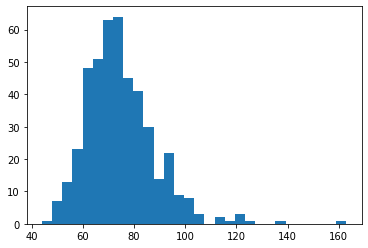

In [125]:
familiar_features = ['Age','Sex','Height','Weight','Heart rate bpm'] #list of well known features with missing data

#function that creates an histogram for a feature
def print_hist(df,feature,nbins):
    print("Histogram for " + feature + ":")
    column = df[feature]
    plt.hist(column,bins=nbins)
    plt.show()

for feature in familiar_features: print_hist(df1,feature,30)

<font color='darkblue'>
Age feature:

In [126]:
df1['Age'].value_counts().sort_index() #get different values and count occurences for each value

0     1
1     2
3     1
7     3
8     2
     ..
78    2
79    1
80    2
81    1
83    1
Name: Age, Length: 77, dtype: int64

In [127]:
df1[df1['Age']==0] #select occurence with Age=0

,Age,Sex,Height,Weight,QRS Duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,V6_WA_Q Wave,V6_WA_R Wave,V6_WA_S Wave,V6_WA_R' Wave,V6_WA_S' Wave,V6_WA_P Wave,V6_WA_T Wave,V6_WA_QRSA,V6_WA_QRSTA,Class
316,0,0,608,10,83,126,232,128,60,125,...,-0.7,4.5,-5.5,0.0,0.0,0.5,2.5,-11.8,1.7,Risk


<font color='darkblue'>
The presence of an individual with Age = 0 and Weight = 10 kgs (probably a baby) suggests that height = 608 cm is actually 61 cm. I should correct height for this instance:

In [128]:
df1.loc[df1["Age"] == 0, "Height"] = 61

<font color='darkblue'>
Height feature:

In [129]:
df1['Height'].value_counts().sort_index()

61      1
105     1
110     1
119     1
120     2
124     1
127     1
130     2
132     1
133     1
138     1
140     1
146     1
148     1
149     1
150     9
152     1
153     5
154     4
155    23
156    19
157    10
158     9
159     6
160    81
161     5
162    15
163    16
164     9
165    46
166     9
167     8
168    15
169     7
170    40
171     9
172    14
173     7
174     4
175    21
176    10
177     4
178     9
179     1
180     4
181     1
182     2
184     1
185     3
186     3
188     1
190     3
780     1
Name: Height, dtype: int64

In [130]:
df1[df1['Height']==780] #select occurence with Height=780

,Age,Sex,Height,Weight,QRS Duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,V6_WA_Q Wave,V6_WA_R Wave,V6_WA_S Wave,V6_WA_R' Wave,V6_WA_S' Wave,V6_WA_P Wave,V6_WA_T Wave,V6_WA_QRSA,V6_WA_QRSTA,Class
141,1,1,780,6,85,165,237,150,106,88,...,0.0,5.0,-4.6,0.0,0.0,1.3,0.7,2.7,5.5,Risk


<font color='darkblue'>
The presence of another baby with incorrect height (780 cm) suggests another typo to correct:

In [131]:
df1.loc[df1["Height"] == 780, "Height"] = 78

<font color='darkblue'>
Looking for features with one-level cardinality (non-informative features):

In [132]:
one_levels = [] #create an empty list to append features with one level

ncol = df1.shape[1] # store number of columns

#for loop to add features names with one level to "one_levels" list 
for index in range(ncol):
    if len(df1.iloc[:,index].unique()) == 1:
        one_levels.append(df1.columns[index])

one_levels

["DI_WW_S' Wave",
 "AVL_WW_S' Wave",
 'AVL_WW_Ragged R wave',
 'AVF_WW_Ragged P wave',
 'V4_WW_Ragged P wave',
 'V4_WW_Diphasic Deriviation P',
 "V5_WW_S' Wave",
 'V5_WW_Ragged R wave',
 'V5_WW_Ragged P wave',
 'V5_WW_Ragged T Wave',
 "V6_WW_S' Wave",
 'V6_WW_Diphasic Deriviation P',
 'V6_WW_Ragged T Wave',
 "DI_WA_S' Wave",
 "AVL_WA_S' Wave",
 "V5_WA_S' Wave",
 "V6_WA_S' Wave"]

<font color='darkblue'>
All those features have only one level and therefore should be eliminated once they don't add knowledge to the dataset.

In [133]:
df2 = df1.copy()
df2 = df1.drop(columns=one_levels) # delete one_level columns 

<font color='darkblue'>
Checking for missing values:

In [134]:
df2.isnull().sum().sum() #total number of missing values is 408

408

In [135]:
#print columns with missing values and its occurences
missing = df2.isnull().sum()
missing_df = pd.DataFrame(missing)
missing_df[missing_df[0]!=0]

,0
T,8
P,22
QRST,1
J,376
Heart rate bpm,1


<font color='darkblue'>
From the output above, there are few features with missing values. Furthermore, there's one feature (feature J) with 376 missing values. This represents 83% of the occurences in the dataset and for that reason I will delete this feature from the dataset. The rationale behind this is the rule of thumb of removing features with more than 60% of missing data (based on Kelleher et al, 2013 page 67).

In [136]:
df3 = df2.copy()
df3 = df3.drop(columns=['J'])
df3

,Age,Sex,Height,Weight,QRS Duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,V6_WA_JJ Wave,V6_WA_Q Wave,V6_WA_R Wave,V6_WA_S Wave,V6_WA_R' Wave,V6_WA_P Wave,V6_WA_T Wave,V6_WA_QRSA,V6_WA_QRSTA,Class
0,75,0,190,80,91,193,371,174,121,-16,...,-0.3,0.0,9.0,-0.9,0.0,0.9,2.9,23.3,49.4,Risk
1,56,1,165,64,81,174,401,149,39,25,...,-0.5,0.0,8.5,0.0,0.0,0.2,2.1,20.4,38.8,Risk
2,54,0,172,95,138,163,386,185,102,96,...,0.9,0.0,9.5,-2.4,0.0,0.3,3.4,12.3,49.0,Risk
3,55,0,175,94,100,202,380,179,143,28,...,0.1,0.0,12.2,-2.2,0.0,0.4,2.6,34.6,61.6,Normal
4,75,0,190,80,88,181,360,177,103,-16,...,-0.4,0.0,13.1,-3.6,0.0,-0.1,3.9,25.4,62.8,Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,0.0,0.0,4.3,-5.0,0.0,0.7,0.6,-4.4,-0.5,Normal
448,37,0,190,85,100,137,361,201,73,86,...,-0.5,0.0,15.6,-1.6,0.0,0.4,2.4,38.0,62.4,Risk
449,36,0,166,68,108,176,365,194,116,-85,...,1.2,0.0,16.3,-28.6,0.0,1.5,1.0,-44.2,-33.2,Risk
450,32,1,155,55,93,106,386,218,63,54,...,0.2,-0.4,12.0,-0.7,0.0,0.5,2.4,25.0,46.6,Normal


<font color='darkblue'>
Handling missing values: for the remaining features with missing values I will impute mean or median values depending on histogram distribution.

Histogram for P:


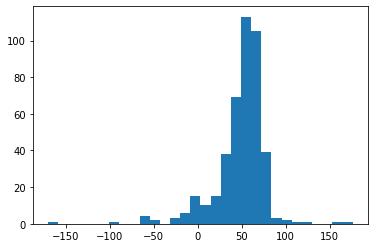

Histogram for T:


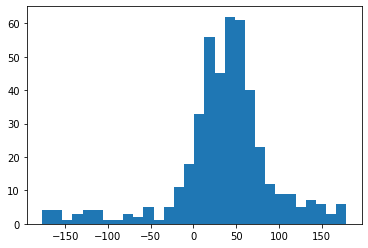

Histogram for QRST:


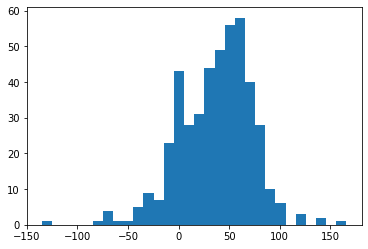

Histogram for Heart rate bpm:


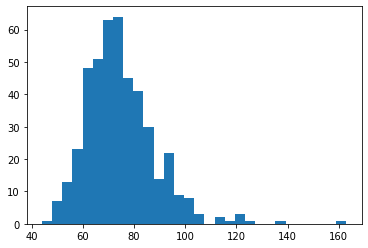

In [137]:
missing_features = ['P','T','QRST','Heart rate bpm'] #list pf features with missing data

for feature in missing_features: print_hist(df3,feature,30)

<font color='darkblue'>
All histograms seem to be skewed so I will impute median values using sci-kit library "impute". 

In [138]:
from sklearn.impute import SimpleImputer

df4 = df3.copy() #create a new copy of the dataset
X_df = df4.loc[:,df4.columns != 'Class'] #select all features except target feature
X = np.array(X_df) #convert it to array (Simple Imputer doesn't work with dataframes)
imp = SimpleImputer(missing_values=np.nan, strategy='median') #create imp object to impute median in all missing values 
imp = imp.fit(X) #calculate median values of the features with missing values
X_imp = imp.transform(X) #fill dataset with median values wherever finds missing values

<font color='darkblue'>
Check if there are any missing values:

In [139]:
np.isnan(X_imp).sum().sum() #total number of missing values in the dataset

0

<font color='darkblue'> 
### Predictions <br>

<font color='darkblue'>
I will start by splitting the dataset in train and test sets. Note that I set random_state = 1 so I ensure that if I need to do another split later this seed will be kept constant so the same instances are splitted.

In [140]:
from sklearn.model_selection import train_test_split

y = df4.iloc[:,-1] #subset target label

# splitting train and test data with same seed (random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=1) #70%/30% splitting

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(316, 261)
(136, 261)
(316,)
(136,)


<font color='darkblue'>
In code below I will count the number of instances in test set that belong to each class. This is important for the interpretation of the confusion matrix.

In [141]:
print('Normal instances in test set: ' + str(sum(y_test=="Normal")))
print('Risk instances in test set: ' + str(sum(y_test=="Risk"))) 

Normal instances in test set: 73
Risk instances in test set: 63


<font color='darkblue'>
In code below I will create my baseline model. I will use random_state = 1 in the classifier and in the further classifiers below so I can make a fair comparison when evaluating performance each time I fit the model to the data.

In [142]:
#create classifier object
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(n_estimators=10,random_state=1) #create classifier object
fit_model1 = clf1.fit(X_train,y_train) #train classifier
y_pred = fit_model1.predict(X_test) #create predictions vector

cm_m1 = metrics.confusion_matrix(y_test,y_pred)
print("Confusion matrix:")
print(cm_m1)

print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_pred)*100,2))+"%")

Confusion matrix:
[[53 20]
 [18 45]]
Accuracy: 72.06%


<font color='darkblue'>
Feature selection

<font color='darkblue'>
As this is a high dimensional dataset (this is the case of a sparsely populated feature space where there are few instances for  many features) and based on the information that some attributes have strong correlation with others I will perform a feature selection.

<font color='darkblue'>
I will first normalize all the values using a range [0,1] normalization to avoid negative values in the chi-square test. Chi-square scores will give me an idea of how related each features are with the target feature.

In [143]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #MinMaxScaler default is [0,1] normalization of features
X_norm = scaler.fit_transform(X_imp)

<font color='darkblue'>
Scores of each feature:

In [144]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feat_test = SelectKBest(score_func=chi2, k=100) # k = 100 is not important at this stage (I just want to check the scores)

feat_fit = feat_test.fit(X_norm,y) # chi2 test over all normalised dataset

np.set_printoptions(precision=6, suppress=True) # set precision and avoid scientific notation for scores print
scores = feat_fit.scores_ 
print(scores)

[ 0.005425 10.138491  0.018572  0.012606  2.556128  0.028024  0.000001
  1.56365   0.143958  0.073812  0.000271  0.000301  0.007586  0.233573
  0.190674  0.027255  2.492172  0.916179  0.157892  1.183575  0.067676
  0.067676  2.36715   2.36715   4.7343    0.909555  0.003411  3.753681
  0.059854  1.437198  0.197977  0.056946  5.073967  1.183575  0.014236
  0.014236  1.852709  0.496177  0.23938   0.238964  0.277537  1.118729
  0.517553  0.844898  0.704348  0.844898  3.572947  0.406353  2.36715
  0.118254  3.048393  1.073832  2.158335  0.844898  1.252266  1.340388
  2.36715   0.014236  2.36715   2.36715   4.7343    0.025426  0.464783
  2.107428  0.00007   1.466595  0.899182  0.844898  1.183575  0.187722
  1.183575  5.140612  0.020649  2.156372  0.622138  2.689943  0.694774
  2.36715   0.339195  0.844898  0.844898  1.183575  4.689063  0.087597
  1.651834 17.237456  0.724852  4.643192  3.550725  8.285024  0.028473
  1.374268  0.067676  0.071182 13.82464   0.007354  0.365345  9.666134
  2.958

<font color='darkblue'>
From the output above, features with a higher score are more related with the target feature. There are some features where chi-square score was almost zero which mean that a feature selection process should eliminate those features.

<font color='darkblue'>
We can also antecipate from the correlation plot below that there are quite a few instances that are correlated (in yellow) and might be redundant and consequently eliminated in a feature selection process.

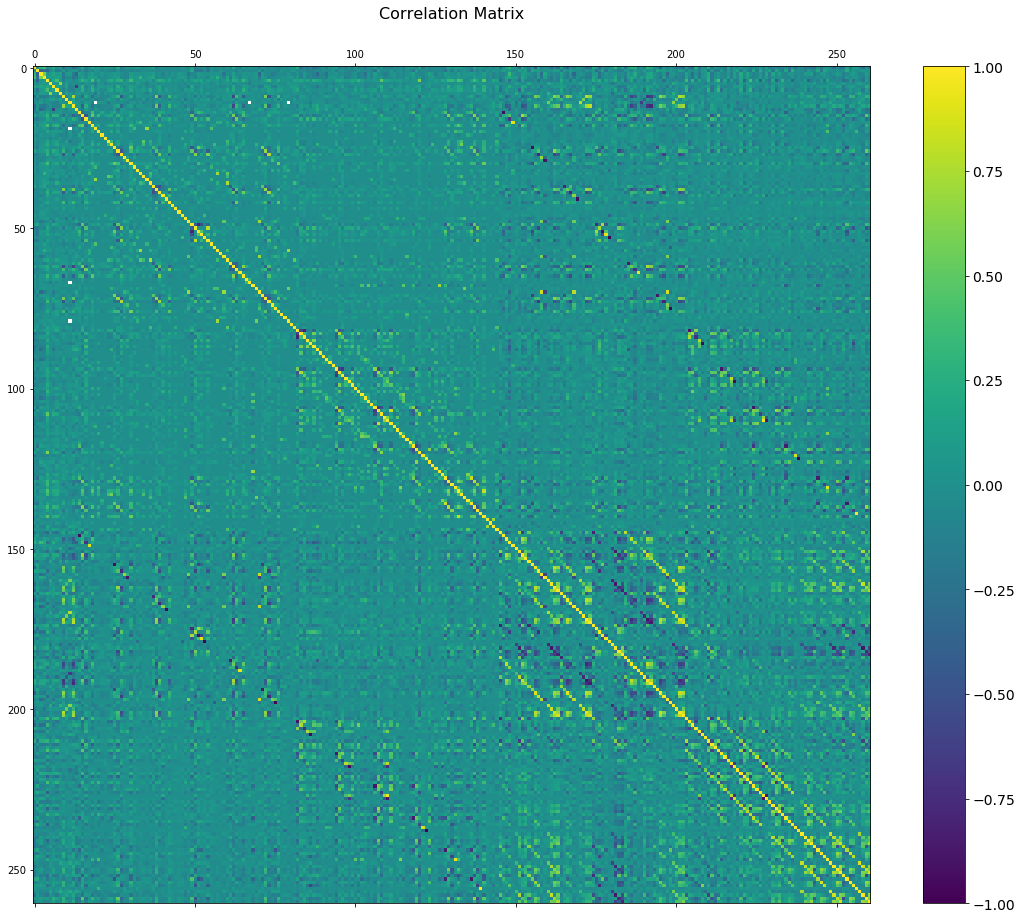

In [145]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df4.corr(), fignum=f.number)
#plt.xticks(range(df4.shape[1]), df4.columns, fontsize=14, rotation=45)
#plt.yticks(range(df4.shape[1]), df4.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

<font color='darkblue'>
Before going to feature selection process itself I will train and evaluate again my model with normalized instances (and same seeds) to obtain a baseline model.

In [146]:
# splitting train and test data with same seed (random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_norm, y, test_size=0.3, random_state=1) #70%/30% splitting

print('Normal instances in test set: ' + str(sum(y_test2=="Normal")))
print('Risk instances in test set: ' + str(sum(y_test2=="Risk")))

fit_model2 = clf1.fit(X_train2,y_train2) #train classifier
y_pred2 = fit_model2.predict(X_test2) #create predictions vector

cm_m2 = metrics.confusion_matrix(y_test2,y_pred2)
print("Confusion matrix (normalized dataset):")
print(cm_m2)

print("Accuracy: " + str(round(metrics.accuracy_score(y_test2, y_pred2)*100,2))+"%")

Normal instances in test set: 73
Risk instances in test set: 63
Confusion matrix (normalized dataset):
[[52 21]
 [18 45]]
Accuracy: 71.32%


<font color='darkblue'>
From the output above, accuracy has slighly decreased after normalization (there was an extra instance predicted as "Risk" being "Normal").

<font color='darkblue'>
In the code chunk below, I will go through the feature selection process. I will use Recursive Feature Elimination (RFE) which is a type of wrapper feature selection method. According with Kelleher et al, 2013 (Galaxy classification case study Page 503), feature selection approaches that search through subsets of features (known as wrapper approaches) are better at removing redundant features together than rank prune approaches because they consider groups of features together. <br>
    
It is important to refer that I will do a feature selection using the instances from the previous normalized training set and not the entire dataset. This ensures that not only predictions but also the feature selection process of my model are made over unseen instances and that avoids any potential bias arising from the feature selection process. 

In [147]:
from sklearn.feature_selection import RFE

#define a function to train and evaluate a random forest algorithm in a reduced feature space varying the number of features
# and recursively selecting the optimal subset of features using RFE (Feature ranking with recursive feature elimination) 
#from skelearn

def evaluate_feature_reduction_RFE(nfeat):

    selector = RFE(clf1,n_features_to_select=nfeat) # n_features_to_select (number of features) will vary

    best_feats = selector.fit(X_train2, y_train2) #get k best features from normalized training dataset (not all dataset!)

    cols = best_feats.get_support(indices=True) # get best columns indexes to use later when selecting test subset

    X_train_reduced = best_feats.transform(X_train2)  # get train dataframe with feature reduction

    fit_model3 = clf1.fit(X_train_reduced, y_train2) # train model with feature reduction

    X_test3 = X_test2[:,cols] #select same best columns from the unseen test set using indexes stored previously

    y_pred3 = fit_model3.predict(X_test3) #make predictions with unseen instances and those that weren't used in feature selection

    accuracy = round(metrics.accuracy_score(y_test2,y_pred3)*100,3) #compute accuracy for model with k subset of features
    
    return accuracy

accuracies = [evaluate_feature_reduction_RFE(i) for i in range(1,X_train2.shape[1]+1)]

print(accuracies)

[51.471, 64.706, 72.059, 78.676, 75.0, 74.265, 77.941, 77.206, 75.0, 77.941, 73.529, 76.471, 76.471, 80.882, 75.735, 77.206, 70.588, 77.941, 80.147, 77.941, 80.147, 75.0, 72.794, 71.324, 75.0, 77.941, 75.0, 76.471, 75.0, 72.059, 78.676, 74.265, 72.794, 75.0, 80.147, 77.206, 77.206, 76.471, 72.794, 83.088, 72.059, 76.471, 78.676, 72.794, 76.471, 75.735, 72.059, 75.0, 74.265, 78.676, 71.324, 76.471, 77.941, 77.941, 74.265, 76.471, 78.676, 79.412, 76.471, 77.206, 77.206, 77.206, 75.0, 78.676, 72.059, 72.794, 75.0, 78.676, 75.735, 76.471, 75.735, 70.588, 76.471, 81.618, 75.735, 75.0, 77.206, 75.735, 76.471, 78.676, 75.735, 76.471, 71.324, 79.412, 72.794, 72.059, 76.471, 78.676, 78.676, 78.676, 76.471, 75.735, 76.471, 68.382, 77.206, 82.353, 78.676, 76.471, 72.059, 74.265, 79.412, 76.471, 70.588, 77.206, 77.206, 80.882, 72.794, 81.618, 83.088, 75.735, 76.471, 76.471, 77.941, 79.412, 77.206, 73.529, 76.471, 77.941, 75.735, 72.794, 75.735, 75.0, 75.0, 82.353, 79.412, 75.735, 77.941, 71.324, 7

<font color='darkblue'>
Getting the maximum value of accuracy and number of features used to achieve it:

In [148]:
best_nfeat = np.argmax(np.array(accuracies))+1
print("Highest accuracy obtained with " + str(best_nfeat) + " features")


Highest accuracy obtained with 40 features


<font color='darkblue'>
    
### Evaluation <br>


<font color='darkblue'>
On the evaluation step I will evaluate my model with the optimal reduced subset of features (40 features).

In [149]:
selector = RFE(clf1,n_features_to_select=best_nfeat) #best number of features
best_feats = selector.fit(X_train2, y_train2) #get best features from normalized training dataset (not all dataset!)
cols = best_feats.get_support(indices=True) # get best columns indexes to use later when selecting test subset
X_train_reduced = best_feats.transform(X_train2)  # get train dataframe with feature reduction
fit_model3 = clf1.fit(X_train_reduced, y_train2) # train model with feature reduction
X_test3 = X_test2[:,cols] #select same best columns from the unseen test set using indexes stored previously
y_pred3 = fit_model3.predict(X_test3) #make predictions with unseen instances and those that weren't used in feature selection
accuracy = round(metrics.accuracy_score(y_test2,y_pred3)*100,3) #compute accuracy for model with 40 features

cm_m3 = metrics.confusion_matrix(y_test2,y_pred3)
print("Confusion matrix (reduced dataset):")
print(cm_m3)
print("Accuracy: " + str(accuracy)+"%")


Confusion matrix (reduced dataset):
[[68  5]
 [18 45]]
Accuracy: 83.088%


<font color='darkblue'>
I will also compute average class accuracy in cell below. In fact there are some instances predicted as "Normal" when in fact they are "Risk" class instances.

In [150]:
print("Average class accuracy: " + str(round(calc_avg_class_acc_am(cm_m3)*100,2)) + "%")

Average class accuracy: 82.29%


<font color='darkblue'>
Finally, in cell below I compute the area under the Receiver Operating Characteristic Curve (ROC AUC) from the prediction scores. This model achieves a value (0.864) well above 0.5 (which would be a random prediction model).

In [151]:
from sklearn.metrics import roc_auc_score

y_pred_prob = fit_model3.predict_proba(X_test3) #prediction probabilities vector [P(Normal), P(Risk)]

print('ROC:' + str(round(roc_auc_score(y_test2, y_pred_prob[:,1]),3)))


ROC:0.864


<font color='darkblue'>
The fact that the model uses only 40 features instead of the total 279 descriptive features is a very important gain in terms of computational resources saved, especially if the dataset increases or if the model becomes stale (due to concept drift, for example) and a lazy algorithm is preferred. I would monitor the cases of false negatives and if this figure increased I would investigate further, once it is an unwanted situation in medical diagnosis. I also would monitor the outputs of the model over time and if significant deviations from the original outputs occured, the implementation of a stability index would help me to identify concept drift. Finally, whenever the representativeness of all classes achieved acceptable levels, I could develop an extended version of the model to discriminate the different classes of arrythmia in a multi-class prediction problem.